# 모델 불러오기

In [1]:
# Colab에 Mecab 설치
!pip install konlpy
!pip install mecab-python
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 31.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.7/581.7 kB 25.8 MB/s eta 0:00:00
  Created wheel for mecab-python: filename=mecab_python-1.0.0-py3-none-any.whl size=1230 sha256=792fd5141ab6ba6c8e95ec38891c2abc327df5110dc00cdf554d11f6d133c03d
  Stored in directory: /root/.cache/pip/wheels/ec/41/c8/ce8fb469be2547ce596c4000613806505dc54c296aae45da71
Successfully built mecab-python
Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0   524k      0  0:00:02  0:00:02 --:--:--  716k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/exam

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터 불러오기 및 전처리

In [3]:
total_data = pd.read_csv('data.csv', encoding='UTF8')
print('전체 데이터 수:', len(total_data))

전체 데이터 수: 10917


In [4]:
total_data[:10]

,label,text
0,NELL,Wanderer 언제부턴가 말 한마디가
1,NELL,언제부턴가 말 한마디가 너무 무거워
2,NELL,말 한마디가 너무 무거워 한숨으로 바뀌어만 가
3,NELL,너무 무거워 한숨으로 바뀌어만 가 언제였을까
4,NELL,한숨으로 바뀌어만 가 언제였을까 생각도 안 나
5,NELL,언제였을까 생각도 안 나 거짓 없는 감정에 충실한 그런 대화
6,NELL,생각도 안 나 거짓 없는 감정에 충실한 그런 대화 진심이 있음 뭐해
7,NELL,거짓 없는 감정에 충실한 그런 대화 진심이 있음 뭐해 숨겨야 하는데
8,NELL,진심이 있음 뭐해 숨겨야 하는데 웃고 있으면 뭐해
9,NELL,숨겨야 하는데 웃고 있으면 뭐해 눈물이 나는데


In [5]:
total_data['label'] = total_data['label'].replace(['NELL', 'OTHER'], [1,0])
total_data[:10]

,label,text
0,1,Wanderer 언제부턴가 말 한마디가
1,1,언제부턴가 말 한마디가 너무 무거워
2,1,말 한마디가 너무 무거워 한숨으로 바뀌어만 가
3,1,너무 무거워 한숨으로 바뀌어만 가 언제였을까
4,1,한숨으로 바뀌어만 가 언제였을까 생각도 안 나
5,1,언제였을까 생각도 안 나 거짓 없는 감정에 충실한 그런 대화
6,1,생각도 안 나 거짓 없는 감정에 충실한 그런 대화 진심이 있음 뭐해
7,1,거짓 없는 감정에 충실한 그런 대화 진심이 있음 뭐해 숨겨야 하는데
8,1,진심이 있음 뭐해 숨겨야 하는데 웃고 있으면 뭐해
9,1,숨겨야 하는데 웃고 있으면 뭐해 눈물이 나는데


In [6]:
# text 열에서 중복인 내용이 있다면 중복 제거
total_data.drop_duplicates(subset=['text'], inplace=True)
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 8483


In [7]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8483 entries, 0 to 10916
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   8483 non-null   int64 
 1   text    8483 non-null   object
dtypes: int64(1), object(1)
memory usage: 198.8+ KB


<Axes: xlabel='label'>

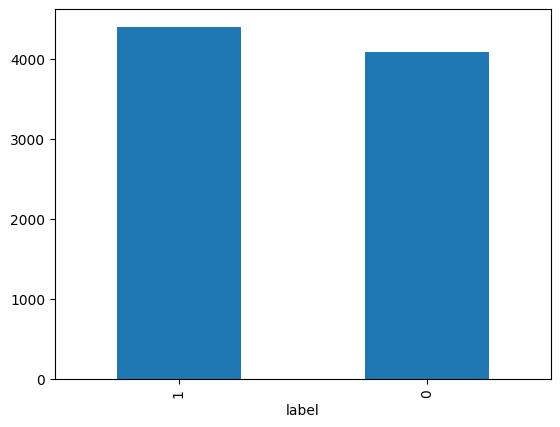

In [8]:
total_data['label'].value_counts().plot(kind='bar')

## 데이터 정제하기

In [9]:
total_data['text'] = total_data['text'].str.replace("[^ㄱ-ㅎ가-힣a-zA-Z ]","", regex=True)
total_data['text'].replace('', np.nan, inplace=True)
print(total_data.isnull().sum())

label    0
text     0
dtype: int64


In [10]:
total_data[:10]

,label,text
0,1,Wanderer 언제부턴가 말 한마디가
1,1,언제부턴가 말 한마디가 너무 무거워
2,1,말 한마디가 너무 무거워 한숨으로 바뀌어만 가
3,1,너무 무거워 한숨으로 바뀌어만 가 언제였을까
4,1,한숨으로 바뀌어만 가 언제였을까 생각도 안 나
5,1,언제였을까 생각도 안 나 거짓 없는 감정에 충실한 그런 대화
6,1,생각도 안 나 거짓 없는 감정에 충실한 그런 대화 진심이 있음 뭐해
7,1,거짓 없는 감정에 충실한 그런 대화 진심이 있음 뭐해 숨겨야 하는데
8,1,진심이 있음 뭐해 숨겨야 하는데 웃고 있으면 뭐해
9,1,숨겨야 하는데 웃고 있으면 뭐해 눈물이 나는데


In [11]:
total_data[:-10]

,label,text
0,1,Wanderer 언제부턴가 말 한마디가
1,1,언제부턴가 말 한마디가 너무 무거워
2,1,말 한마디가 너무 무거워 한숨으로 바뀌어만 가
3,1,너무 무거워 한숨으로 바뀌어만 가 언제였을까
4,1,한숨으로 바뀌어만 가 언제였을까 생각도 안 나
...,...,...
10892,0,복잡한 음정과 리듬에서도 Ill always be with you Accelerando
10893,0,Ill always be with you Accelerando 절정으로 올라가자
10904,0,Good vibe 잃지 않고 가 절대 마에스트로의 지휘에 맞춰 리듬은 DAT DA ...
10905,0,마에스트로의 지휘에 맞춰 리듬은 DAT DA DA RAT DA Brass는 BA B...


In [12]:
mecab = Mecab()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [13]:
total_data['token'] = total_data['text'].apply(mecab.morphs)
total_data['token'] = total_data['token'].apply(lambda x: [item for item in x if item not in stopwords])

In [14]:
total_data[:-10]

,label,text,token
0,1,Wanderer 언제부턴가 말 한마디가,"[Wanderer, 언제, 부턴가, 말, 한마디]"
1,1,언제부턴가 말 한마디가 너무 무거워,"[언제, 부턴가, 말, 한마디, 너무, 무거워]"
2,1,말 한마디가 너무 무거워 한숨으로 바뀌어만 가,"[말, 한마디, 너무, 무거워, 한숨, 으로, 바뀌, 어, 만]"
3,1,너무 무거워 한숨으로 바뀌어만 가 언제였을까,"[너무, 무거워, 한숨, 으로, 바뀌, 어, 만, 언제, 였을까]"
4,1,한숨으로 바뀌어만 가 언제였을까 생각도 안 나,"[한숨, 으로, 바뀌, 어, 만, 언제, 였을까, 생각, 안, 나]"
...,...,...,...
10892,0,복잡한 음정과 리듬에서도 Ill always be with you Accelerando,"[복잡, 음정, 리듬, 에서, Ill, always, be, with, you, A..."
10893,0,Ill always be with you Accelerando 절정으로 올라가자,"[Ill, always, be, with, you, Accelerando, 절정, ..."
10904,0,Good vibe 잃지 않고 가 절대 마에스트로의 지휘에 맞춰 리듬은 DAT DA ...,"[Good, vibe, 잃, 않, 절대, 마에스트로, 지휘, 맞춰, 리듬, DAT,..."
10905,0,마에스트로의 지휘에 맞춰 리듬은 DAT DA DA RAT DA Brass는 BA B...,"[마에스트로, 지휘, 맞춰, 리듬, DAT, DA, DA, RAT, DA, Bras..."


## 데이터 분할

In [15]:
X_data = total_data['token']
Y_data = total_data['label']

X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=0)

In [16]:
X_train[:10]

,token
3575,"[사실, 난, 아주, 아름다울, 테, 니, 그러, 니, 부디, 놓, 아, 버리, 말..."
9598,"[Drop, a, red, light, and, well, sing, it, goo..."
6923,"[Everybody, make, it, loud, Make, it, loud, Up..."
3406,"[익숙, 긴, 지만, 여전히, 낯설, 버텨, 긴, 지만, 힘든, 건, 여전, 해, ..."
7680,"[속도, 올렸, 어, 망설이, 전부, 놓쳐, 버릴까, 또, 일곱, 번, 여름, 없,..."
3686,"[이젠, 용서, 해요, 일초, 일, 분, 처럼, 또, 하루, 일, 년, 처럼]"
2741,"[잊, 싶, 게끔, 만들, 어, 완전, 해, Keep, whispering, love]"
6597,"[Baby, dont, say, no, 정반대, 같, 아, our, type, 넌,..."
4470,"[보일, 말, 희미, 지만, 좀, 도와, 주, 세요]"
8043,"[Gonna, block, you, 불, 꺼, To, X, Say, Bye]"


In [17]:
Y_train[:10]

,label
3575,1
9598,0
6923,0
3406,1
7680,0
3686,1
2741,1
6597,0
4470,1
8043,0


In [18]:
print(X_train, X_test, Y_train, Y_test)

3575     [사실, 난, 아주, 아름다울, 테, 니, 그러, 니, 부디, 놓, 아, 버리, 말...
9598     [Drop, a, red, light, and, well, sing, it, goo...
6923     [Everybody, make, it, loud, Make, it, loud, Up...
3406     [익숙, 긴, 지만, 여전히, 낯설, 버텨, 긴, 지만, 힘든, 건, 여전, 해, ...
7680     [속도, 올렸, 어, 망설이, 전부, 놓쳐, 버릴까, 또, 일곱, 번, 여름, 없,...
                               ...                        
5587                                    [payback, payback]
10166    [I, Shine, 왜, 날, 힘들, 울, 만, 둔, 건지, Hold, Me, Cl...
6222     [막상, 앞, 서, 니, 꽁꽁, 얼, 어, 버렸, 숨겨왔, 던, 나, 맘, 절반, ...
4246               [난, 아직, 난, 멈춰진, 기억, 속, 에서, 이렇게, 헤매, 는데]
3567                              [나, 떠나, 마요, 나, 떠나, 마, 요]
Name: token, Length: 6786, dtype: object 6359     [오늘, 오래, 걸린, 이유, Im, always, so, excited, to, ...
6289      [영화, 같, 스토리, 끝, Its, like, a, movie, 우린, 참, 어렸었]
10866    [Beat, 부터, Melody, 까지, Mix, and, match, 특기, 니까...
6506               [Armageddon, 정의, 해, 이젠, 나, 만, Complete]
10820    [도망쳐, 봐, 어차피, 날, 벗어날, 수, 없, 어, When, I, touch,...
               

## 정수 인코딩

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [20]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 5117
등장 빈도가 1번 이하인 희귀 단어의 수: 368
단어 집합에서 희귀 단어의 비율: 7.19171389486027
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.4019178471183145


In [21]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4751


In [22]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [23]:
print(X_train[:3])

[[397, 17, 292, 1540, 247, 50, 263, 50, 679, 250, 11, 264, 12, 214, 1139, 3, 1859, 19], [646, 33, 1315, 326, 23, 647, 1140, 22, 2727, 474, 1141, 14, 1142, 217, 59, 1699], [934, 154, 22, 1067, 154, 22, 1067, 82, 23, 327, 362, 23, 362, 991, 2728, 452, 935, 327]]


## 패딩

가사의 최대 길이 : 38
가사의 평균 길이 : 13.492631889183613


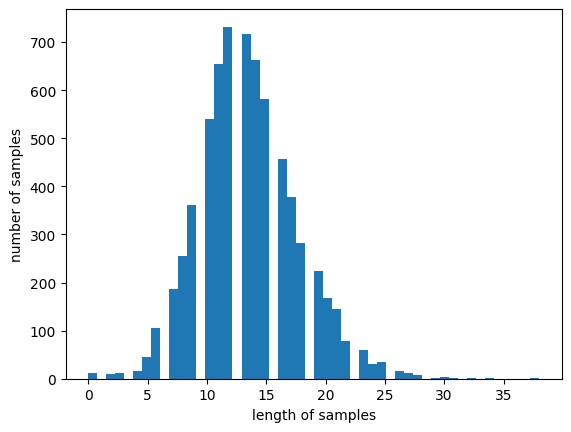

In [24]:
print('가사의 최대 길이 :',max(len(review) for review in X_train))
print('가사의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [25]:
max_len = 35
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# 학습

In [26]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.keras', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, Y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
81/85 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.5603 - loss: 0.6791
Epoch 1: val_acc improved from -inf to 0.80560, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - acc: 0.5647 - loss: 0.6763 - val_acc: 0.8056 - val_loss: 0.4339
Epoch 2/15
84/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.8463 - loss: 0.3669
Epoch 2: val_acc improved from 0.80560 to 0.88881, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8468 - loss: 0.3657 - val_acc: 0.8888 - val_loss: 0.2539
Epoch 3/15
83/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9380 - loss: 0.1556
Epoch 3: val_acc improved from 0.88881 to 0.89985, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.9380 - loss: 0.1557 - val_acc: 0.8999 - val_loss: 0.2413
Epoch 4/15
78/85 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9639 - loss: 0.1108
Epoch 4: val_acc improved from 0.89985 to 0.91900, saving model to best_model.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/s

In [27]:
loaded_model = load_model('best_model.keras')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, Y_test)[1]))

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.9403 - loss: 0.2359

 테스트 정확도: 0.9481


# 확인하기

In [28]:
def predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 넬의 가사입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 넬의 가사가 아닙니다.".format((1 - score) * 100))

In [29]:
predict('여전히 그대로죠 생일은 몇 번씩이나 지났고 분명 나 역시 조금 더')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
88.90% 확률로 넬의 가사입니다.


<ipython-input-28-23861597c177>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [30]:
predict("사람들이 움직이는 게 신기해 팔다리가 앞뒤로 막 움 움 움직이는게")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
99.99% 확률로 넬의 가사가 아닙니다.


<ipython-input-28-23861597c177>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [31]:
predict("기억하나요? 좋았던 순간들이 먼지가 되어 쌓여가네요")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
99.98% 확률로 넬의 가사입니다.


<ipython-input-28-23861597c177>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [32]:
predict("그대란 행운이 온 걸까 지금 우리 함께 있다면 얼마나 좋을까요")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
100.00% 확률로 넬의 가사가 아닙니다.


<ipython-input-28-23861597c177>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [33]:
predict("난 너무나 힘이 들어요 그대 역시 마찬가지잖아요 나는 달라지고 있어요")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
92.79% 확률로 넬의 가사입니다.


<ipython-input-28-23861597c177>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [34]:
def similar(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  print("넬의 가사와 {:.2f}% 유사합니다".format(score * 100))

In [35]:
similar("난 너무나 힘이 들어요 그대 역시 마찬가지잖아요 나는 달라지고 있어요")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
넬의 가사와 92.79% 유사합니다


<ipython-input-34-126770b3c95f>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))


In [36]:
similar("맨발로 기억을 거닐다 떨어지는 낙엽에 그간 잊지 못한")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
넬의 가사와 46.06% 유사합니다


<ipython-input-34-126770b3c95f>:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score = float(loaded_model.predict(pad_new))
